Hackaton

# Index
1. Reading the data
2. Exploratory Data Analysis
    1. Target Variable Distrubution (check if its inbalanced)
    2. Distribution of features
    3. Missing values of features
    4. Correlation of features
    5. Description of the data (df.describe())
    6. Outlier detection (remove nonsensical data / boxplots) / (create a function to remove outliers)
    7. Check distinct values in features / check ordinal values
3. Feature Engineering
    1. Missing value imputation (mode, median, mean, k-NN, SMOTE etc.)
    2. Create new features using arithmetical transformations of existing features.
    3. PCA 
    4. Try few models to decide feature importances to reduce features. (target shuffling)
    5. Add new features using outside data sources.
    6. Train, Test, Validation split (use validation for hyperparameter tuning)
4. Modeling (find important features using models, then return to feature engineering)
    1. Linear Regression (remove multicolonarity, then check coefficient of features to determine their importance) (correlation matrix 85%>)
    2. Decision Tree
    3. Random Forest (entropy)
    4. XGBoost
    5. LightGBM
    6. Neural Network
    7. Ensemble Learning
5. Hyperparameter Tuning
    1. Grid Search
    2. Bayesean Search


    

# Dependencies

In [133]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

from sklearn import linear_model as lin 
from sklearn import preprocessing as pre
from sklearn import metrics as met
from sklearn import model_selection as mod
from sklearn import pipeline as pip
from sklearn import datasets as dat
from sklearn import tree
from sklearn import preprocessing as pre
from sklearn import ensemble as ens
from sklearn import svm
from sklearn import decomposition as dec
from sklearn import manifold as man
from sklearn import impute as imp
from sklearn import compose as com

from imblearn import pipeline as imbPip # imblearn pipeline
from imblearn import under_sampling as und
from imblearn import over_sampling as ove

import xgboost as xgb

import seaborn as sns

from pandas_profiling import ProfileReport as p_rep

import lightgbm as lgbm

np.set_printoptions(suppress=True) 

import warnings
warnings.filterwarnings("ignore")

# Functions

In [3]:
def plotLearningCurve(est, X_train, y_train, X_test, y_test, n_iter=10, minY=0,maxY=1):
    x_values = [] #number of training samples
    y_values_train = []
    y_values_test = []

    for i in np.linspace(10,len(X_train),n_iter): #increase training sizes by every iter
        i=int(i)
        #select a subset of training data
        X_train_temp = X_train[:i]
        y_train_temp = y_train[:i]
        #create the model
        est.fit(X_train_temp, y_train_temp)
        #evaluate train set
        y_pred_train=est.predict(X_train_temp)
        train_score = met.mean_squared_error(y_train_temp,y_pred_train,squared=False)
        #evaluate test set
        y_pred_test=est.predict(X_test)
        test_score = met.mean_squared_error(y_test,y_pred_test,squared=False)
        #populate lists
        y_values_train.append(train_score)
        y_values_test.append(test_score)
        x_values.append(i)
    plt.figure(figsize=(10,6))
    plt.plot(x_values,y_values_train,label="Train")
    plt.plot(x_values,y_values_test, label="Test")
    plt.legend()
    plt.ylabel("RMSE")
    plt.xlabel("# of training samples")
    plt.grid(True)
    plt.ylim(minY,maxY)
    plt.show()

In [4]:
def plotDecisionBoundaries(clf, X, y, n_classes=2):
  # Parameters
  plot_colors = "rb"
  plot_step = 0.02

  X2 = X.values
  y_now = y.values


  for pairidx, pair in enumerate([[0, 1], [0, 2], [0, 3],
                                  [1, 2], [1, 3], [2, 3]]):
      # We only take the two corresponding features
      X_now = X2[:, pair]
      
      

      # Train
      clf.fit(X_now, y_now)

      # Plot the decision boundary
      plt.subplot(2, 3, pairidx + 1)

      x_min, x_max = X_now[:, 0].min() - 1, X_now[:, 0].max() + 1
      y_min, y_max = X_now[:, 1].min() - 1, X_now[:, 1].max() + 1
      xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                          np.arange(y_min, y_max, plot_step))
      plt.tight_layout(h_pad=0.5, w_pad=0.5, pad=2.5)

      Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
      Z = Z.reshape(xx.shape)
      cs = plt.contourf(xx, yy, Z, cmap=plt.cm.RdYlBu)

      

      # Plot the training points
      for i, color in zip(range(n_classes), plot_colors):
          idx = np.where(y_now == i)
          
          plt.scatter(X_now[idx, 0], X_now[idx, 1], c=color,
                      cmap=plt.cm.RdYlBu, edgecolor='black', s=15)

  plt.suptitle("Decision surface of a decision tree using paired features")
  plt.legend(loc='lower right', borderpad=0, handletextpad=0)
  plt.axis("tight")
  plt.show()

In [5]:
def estimate_roc_curve(X_train, y_train_binary, estimators=[[tree.DecisionTreeClassifier(random_state=42),
                lin.SGDClassifier(random_state=42),
                ens.RandomForestClassifier(random_state=42)]]):
    for est in estimators:
        pipe = pip.Pipeline([
            ("scaler", pre.StandardScaler()),
            ("est",est)
        ])
        if hasattr(est,"predict_proba"):
            myMethod = "predict_proba" #returns list of lists
        else:
            myMethod = "decision_function" 

        y_scores = mod.cross_val_predict(pipe, X_train, y_train_binary,
                                        cv=5, method=myMethod)
        if myMethod == "predict_proba":
            y_scores = y_scores[:, 1] #probabilities for true class
        fpr, tpr, thresholds = met.roc_curve(y_train_binary,y_scores)
        auc_score = met.roc_auc_score(y_train_binary,y_scores)
        print(est.__class__.__name__,auc_score)
        plt.plot(fpr, tpr, label=est.__class__.__name__)
    plt.title("ROC Curve")
    plt.xlabel("fpr")
    plt.ylabel("tpr")
    plt.legend()
    plt.show()

In [6]:
def precision_recall_curve(est, X_train, y_train_binary):
    
    pipe = pip.Pipeline([("scaler", pre.StandardScaler())
                         ,("est",est)])
    
    if hasattr(est,"predict_proba"):
        myMethod = "predict_proba" 
    else:
        myMethod = "decision_function" 
    
    y_scores = mod.cross_val_predict(pipe,X_train,y_train_binary,cv=3, method=myMethod)
    
    precision, recall, thresholds = met.precision_recall_curve(y_train_binary, y_scores)
    
    plt.figure(figsize=(10,6))
    plt.plot(thresholds,precision[:-1], label = "precision")
    plt.plot(thresholds,recall[:-1], label = "recall")
    plt.legend()
    plt.xlabel("Thresholds")
    plt.ylabel("Precision / Recall")
    plt.show()
    
    fpr, tpr, thresholds = met.roc_curve(y_train_binary,y_scores)
    plt.plot(fpr,tpr)
    plt.xlabel("fpr")
    plt.ylabel("tpr")
    plt.show()
    

# Main

## 1. Reading the Data

In [7]:
Data_Path = "Data/train.xlsx" #replace with data path
Data_Path2 = "Data/test.xlsx" #replace with data path
Target_Col = "is claim"

In [8]:
df = pd.read_excel(Data_Path)
df = df.set_index("ID")
df.head()

,ncap rating,is power door locks,policyholder age,is parking camera,rear brakes type,is adjustable steering,is tpms,is driver seat height adjustable,segment,car age,...,is parking sensors,power,gross weight,is day night rear view mirror,model,gear box,airbags,turning radius,area danger level,is claim
ID,,,,,,,,,,,,,,,,,,,,,
0,2.0,Yes,0.394496,No,Drum,No,No,No,B1,0.08,...,Yes,55.92bhp@5300rpm,1340.0,No,Model_8,5.0,2.0,4.7,4,0
1,2.0,Yes,0.417364,No,Drum,No,No,No,B1,0.06,...,Yes,55.92bhp@5300rpm,1340.0,No,Model_8,5.0,2.0,4.7,1,1
2,2.0,Yes,0.438922,No,Drum,Yes,No,Yes,B2,0.03,...,Yes,88.50bhp@6000rpm,1335.0,Yes,Model_6,5.0,2.0,4.8,5,0
3,0.0,No,0.656276,No,Drum,No,No,No,A,0.04,...,Yes,40.36bhp@6000rpm,1185.0,No,Model_1,5.0,2.0,4.6,2,0
4,3.0,Yes,0.462328,Yes,Disc,Yes,Yes,Yes,C2,0.04,...,Yes,113.45bhp@4000rpm,1720.0,No,Model_4,6.0,6.0,5.2,3,0


In [9]:
df.head()

,ncap rating,is power door locks,policyholder age,is parking camera,rear brakes type,is adjustable steering,is tpms,is driver seat height adjustable,segment,car age,...,is parking sensors,power,gross weight,is day night rear view mirror,model,gear box,airbags,turning radius,area danger level,is claim
ID,,,,,,,,,,,,,,,,,,,,,
0,2.0,Yes,0.394496,No,Drum,No,No,No,B1,0.08,...,Yes,55.92bhp@5300rpm,1340.0,No,Model_8,5.0,2.0,4.7,4,0
1,2.0,Yes,0.417364,No,Drum,No,No,No,B1,0.06,...,Yes,55.92bhp@5300rpm,1340.0,No,Model_8,5.0,2.0,4.7,1,1
2,2.0,Yes,0.438922,No,Drum,Yes,No,Yes,B2,0.03,...,Yes,88.50bhp@6000rpm,1335.0,Yes,Model_6,5.0,2.0,4.8,5,0
3,0.0,No,0.656276,No,Drum,No,No,No,A,0.04,...,Yes,40.36bhp@6000rpm,1185.0,No,Model_1,5.0,2.0,4.6,2,0
4,3.0,Yes,0.462328,Yes,Disc,Yes,Yes,Yes,C2,0.04,...,Yes,113.45bhp@4000rpm,1720.0,No,Model_4,6.0,6.0,5.2,3,0


In [10]:
num_columns = list(df.drop(Target_Col,axis=1).select_dtypes(exclude="object").columns)
cat_columns = list(df.select_dtypes(include="object").columns)

## 2. Exploratory Data Analysis 

### 1. Target Variable Distribution

In [11]:
df[Target_Col].value_counts(normalize=True, dropna=False)

0    0.936043
1    0.063957
Name: is claim, dtype: float64

### 2. Distribution of Features

array([[<AxesSubplot:title={'center':'ncap rating'}>,
        <AxesSubplot:title={'center':'policyholder age'}>,
        <AxesSubplot:title={'center':'car age'}>,
        <AxesSubplot:title={'center':'height'}>],
       [<AxesSubplot:title={'center':'engine volume'}>,
        <AxesSubplot:title={'center':'manufacturer'}>,
        <AxesSubplot:title={'center':'cylinder'}>,
        <AxesSubplot:title={'center':'population'}>],
       [<AxesSubplot:title={'center':'time period'}>,
        <AxesSubplot:title={'center':'length'}>,
        <AxesSubplot:title={'center':'width'}>,
        <AxesSubplot:title={'center':'gross weight'}>],
       [<AxesSubplot:title={'center':'gear box'}>,
        <AxesSubplot:title={'center':'airbags'}>,
        <AxesSubplot:title={'center':'turning radius'}>,
        <AxesSubplot:title={'center':'area danger level'}>],
       [<AxesSubplot:title={'center':'is claim'}>, <AxesSubplot:>,
        <AxesSubplot:>, <AxesSubplot:>]], dtype=object)

<Figure size 1500x1100 with 0 Axes>

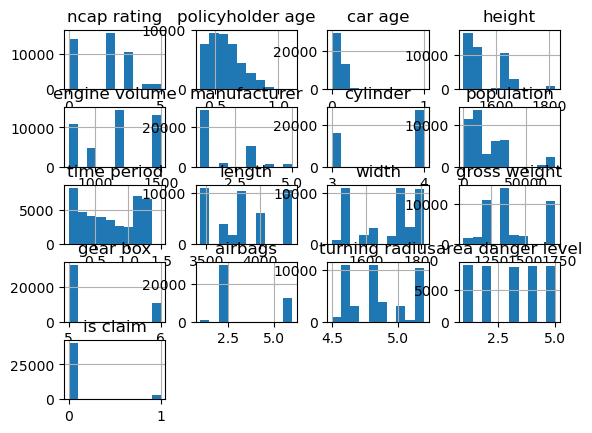

In [12]:
plt.figure(figsize=(15,11))
df.hist()

### 3. Missing values of Features

In [13]:
temp = df.isnull().sum()
miss_values = pd.DataFrame({'Columns': temp.index, 'Missing Values': temp.values})
miss_values.sort_values(by="Missing Values", ascending=False)

,Columns,Missing Values
39,gear box,116
23,is brake assist,105
9,car age,105
31,steering type,104
17,engine volume,103
0,ncap rating,99
41,turning radius,98
36,gross weight,97
29,engine type,97
20,cylinder,97


### 4. Correlation of Features

In [14]:
df.corr()

,ncap rating,policyholder age,car age,height,engine volume,manufacturer,cylinder,population,time period,length,width,gross weight,gear box,airbags,turning radius,area danger level,is claim
ncap rating,1.000000,-0.033303,0.343773,0.435326,0.845585,0.792401,0.595164,-0.073002,0.172605,0.765648,0.769588,0.554333,0.529586,0.339344,0.778156,-0.001806,0.001630
policyholder age,-0.033303,1.000000,-0.028615,-0.053786,-0.024986,-0.032284,0.002794,0.011736,0.147879,-0.020915,-0.007332,-0.007633,-0.003254,-0.007225,-0.017468,0.005639,0.025423
car age,0.343773,-0.028615,1.000000,0.255909,0.390258,0.185279,0.377880,-0.063664,0.164126,0.380467,0.411364,0.300125,0.201008,0.208823,0.330175,0.003787,-0.026804
height,0.435326,-0.053786,0.255909,1.000000,0.553571,0.302524,0.351144,-0.067515,0.114807,0.552770,0.387776,0.728229,0.580726,0.422821,0.459082,-0.000818,-0.002658
engine volume,0.845585,-0.024986,0.390258,0.553571,1.000000,0.753208,0.865335,-0.095923,0.194578,0.961423,0.898680,0.775727,0.692498,0.661052,0.874465,-0.000986,0.004618
manufacturer,0.792401,-0.032284,0.185279,0.302524,0.753208,1.000000,0.408867,-0.038258,0.086976,0.691873,0.510241,0.480226,0.632154,0.500332,0.753535,0.002698,-0.002679
cylinder,0.595164,0.002794,0.377880,0.351144,0.865335,0.408867,1.000000,-0.095629,0.191147,0.804338,0.862082,0.602479,0.409363,0.478638,0.613148,-0.003536,0.009694
population,-0.073002,0.011736,-0.063664,-0.067515,-0.095923,-0.038258,-0.095629,1.000000,-0.101514,-0.096982,-0.102265,-0.081684,-0.060078,-0.065691,-0.081495,-0.005816,-0.019023
time period,0.172605,0.147879,0.164126,0.114807,0.194578,0.086976,0.191147,-0.101514,1.000000,0.192706,0.215294,0.142428,0.098947,0.107878,0.169176,-0.001062,0.079380
length,0.765648,-0.020915,0.380467,0.552770,0.961423,0.691873,0.804338,-0.096982,0.192706,1.000000,0.915444,0.861514,0.809405,0.809534,0.944439,0.001608,0.003860


### 5. Description of the data

In [15]:
df.describe()

,ncap rating,policyholder age,car age,height,engine volume,manufacturer,cylinder,population,time period,length,width,gross weight,gear box,airbags,turning radius,area danger level,is claim
count,43493.000000,43511.000000,43487.000000,43496.000000,43489.000000,43505.000000,43495.000000,43497.000000,43510.000000,43504.000000,43518.000000,43495.000000,43476.000000,43506.000000,43494.000000,43592.000000,43592.000000
mean,1.765525,0.579785,0.069612,1553.528003,1163.993263,1.767682,3.629567,18913.130377,0.711589,3852.270941,1672.877936,1386.221267,5.246803,3.145520,4.854263,2.989218,0.063957
std,1.387897,0.123127,0.057063,79.579923,265.877608,1.138034,0.482926,17667.348845,0.413878,311.124235,111.891735,212.655103,0.431156,1.836644,0.228017,1.416927,0.244679
min,0.000000,0.383477,0.000000,1475.000000,796.000000,1.000000,3.000000,291.000000,0.091397,3445.000000,1475.000000,1051.000000,5.000000,1.000000,4.500000,1.000000,0.000000
25%,0.000000,0.480129,0.020000,1475.000000,796.000000,1.000000,3.000000,6190.000000,0.312787,3445.000000,1515.000000,1185.000000,5.000000,2.000000,4.600000,2.000000,0.000000
50%,2.000000,0.563987,0.060000,1530.000000,1197.000000,1.000000,4.000000,8869.000000,0.673514,3845.000000,1735.000000,1335.000000,5.000000,2.000000,4.800000,3.000000,0.000000
75%,3.000000,0.656721,0.110000,1635.000000,1493.000000,3.000000,4.000000,27086.000000,1.139950,3995.000000,1755.000000,1510.000000,5.000000,6.000000,5.000000,4.000000,0.000000
max,5.000000,1.112216,1.000000,1825.000000,1498.000000,5.000000,4.000000,73529.000000,1.494771,4300.000000,1811.000000,1720.000000,6.000000,6.000000,5.200000,5.000000,1.000000


### 6. Outlier Detection

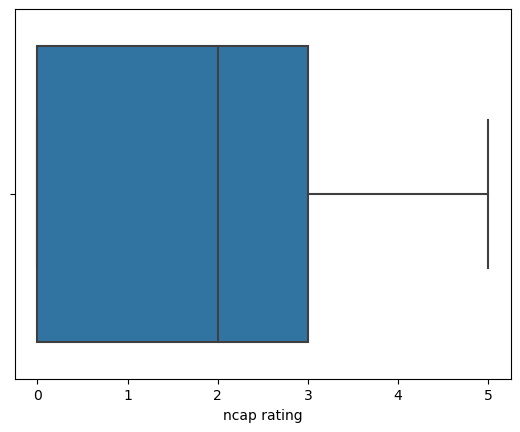

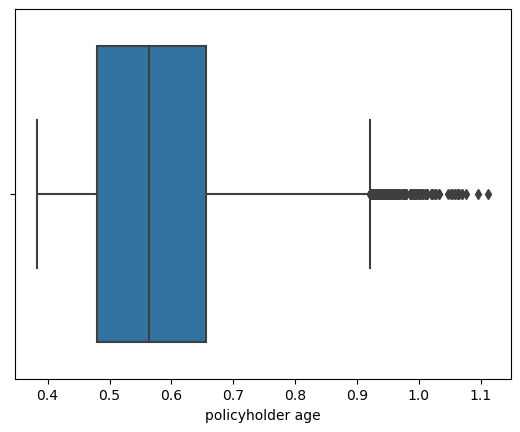

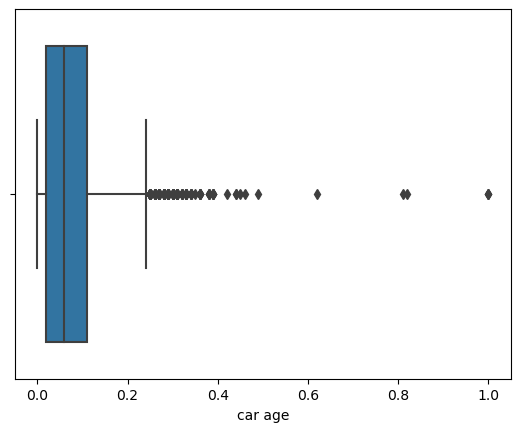

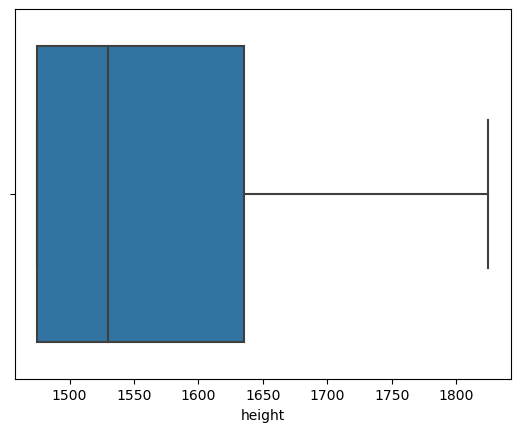

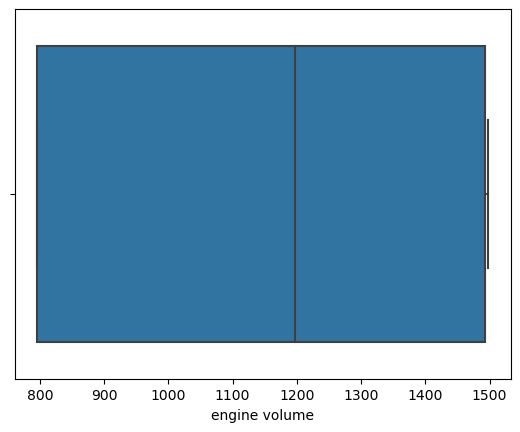

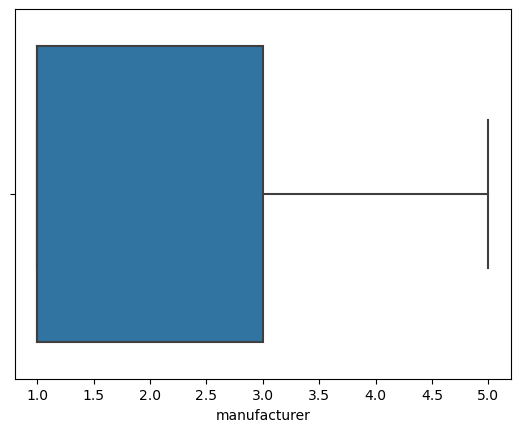

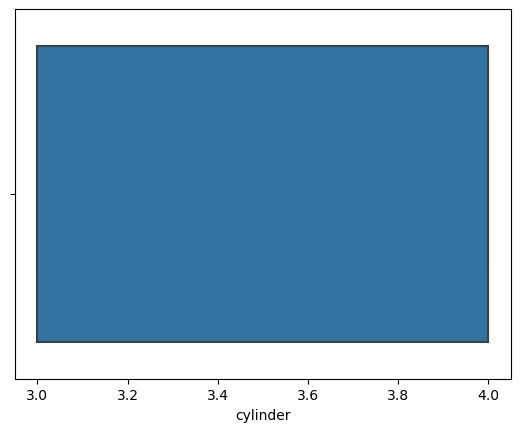

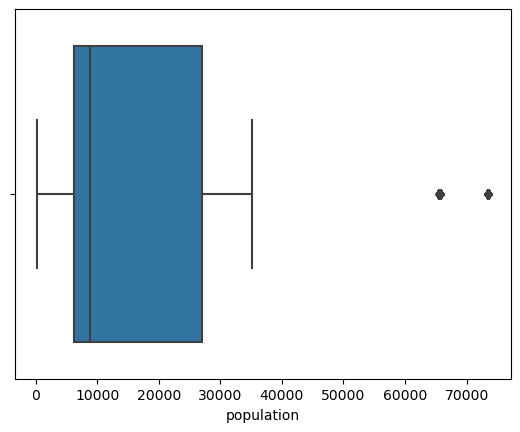

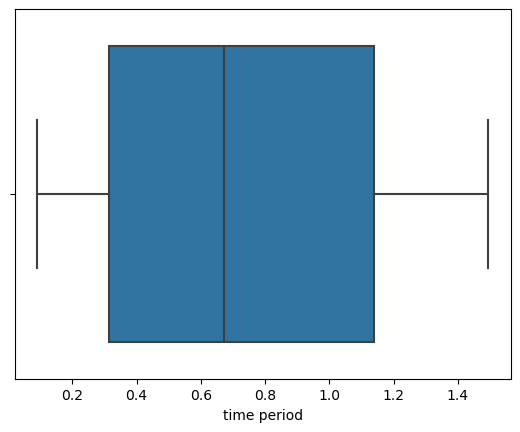

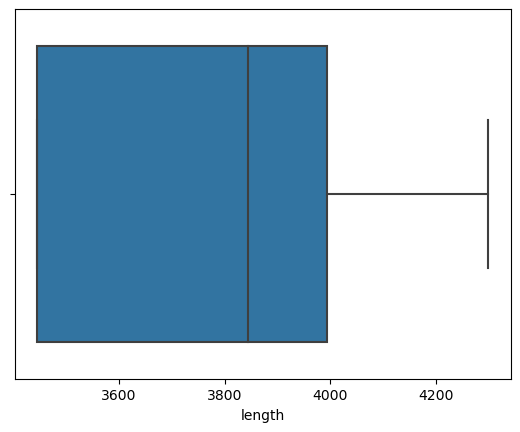

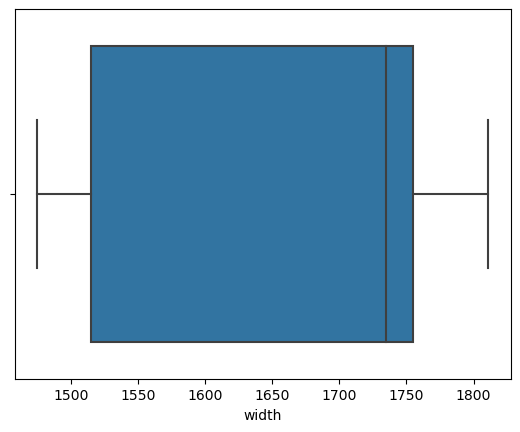

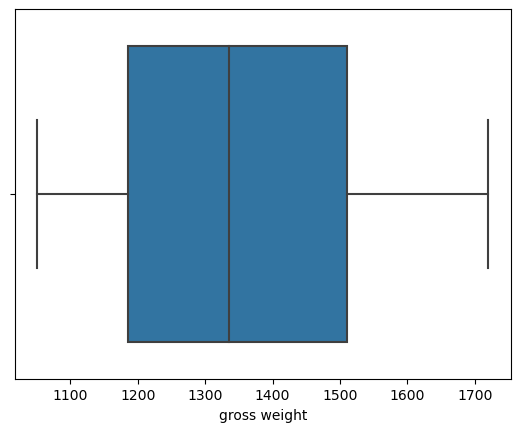

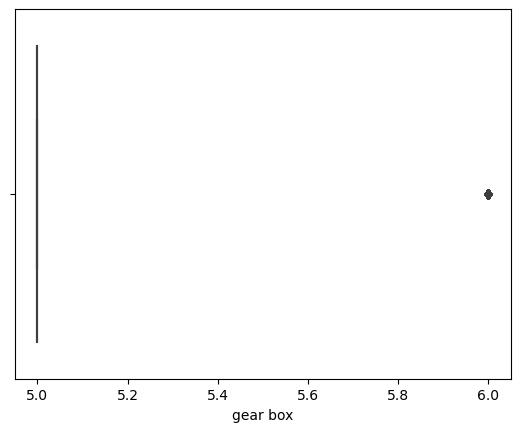

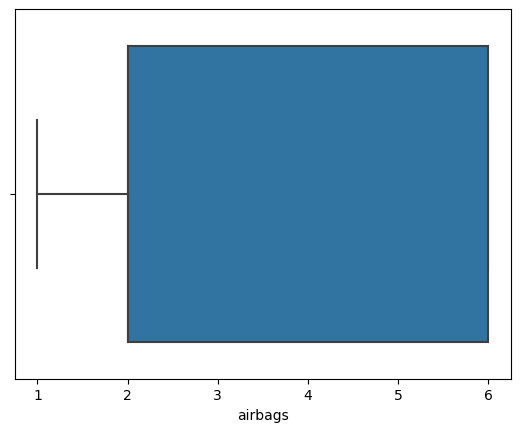

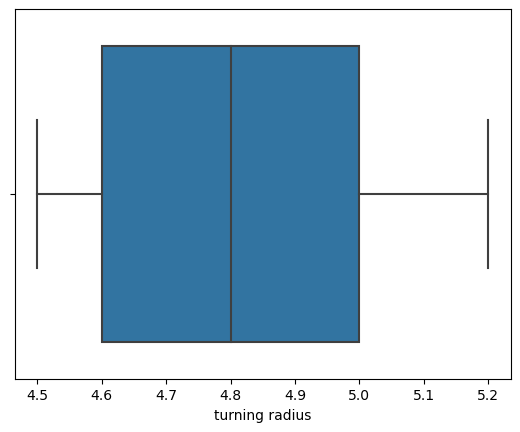

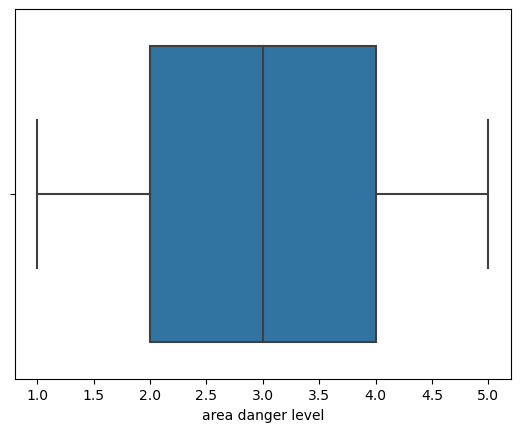

In [16]:
for col in num_columns:
  sns.boxplot(df, x=col)
  plt.show()

In [17]:
# df_profile = p_rep(df, title="Profiling Report")

In [18]:
# df_profile.to_file("data_report.html")

In [20]:
#Identify the unique values
pd.set_option('display.max_rows', None)
dict = {}

for i in list(df.columns):
  dict[i] = df[i].value_counts().shape[0]

uniq = pd.DataFrame(dict, index = ["Unique counts"]).transpose()
uniq.sort_values(by="Unique counts")

,Unique counts
is rear window washer,2
gear box,2
is day night rear view mirror,2
is parking sensors,2
is speed alert,2
is rear window defogger,2
is esc,2
is power steering,2
is brake assist,2
is front fog lights,2


## 3. Feature Engineering

### 1. Missing Value Imputation

# 4. Modeling

## 1. Simple Model

In [21]:
X_train, X_test, y_train, y_test = mod.train_test_split(
    df.drop([Target_Col], axis=1), df[Target_Col], test_size=0.25, random_state=42)


In [22]:
num_columns = list(X_train.select_dtypes(exclude="object").columns)
cat_columns = list(X_train.select_dtypes(include="object").columns)

In [23]:
#ct_num = com.ColumnTransformer([
#    ("num_skewed", pre.FunctionTransformer(np.log1p), num_columns)
#])

pipe_num = pip.Pipeline([
#    ("scaler", pre.StandardScaler()),
    ("imp", imp.SimpleImputer(strategy="mean"))
])

pipe_cat = pip.Pipeline([
    ("imp", imp.SimpleImputer(strategy="most_frequent")),
    ("encoding", pre.OneHotEncoder(handle_unknown="ignore", sparse=True)) 
])

ct = com.ColumnTransformer([
    ("num", pipe_num, num_columns),
    ("cat", pipe_cat, cat_columns)
])

ct.fit_transform(X_test)

array([[2.        , 0.6946975 , 0.13      , ..., 0.        , 0.        ,
        0.        ],
       [3.        , 0.48143506, 0.02      , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.85750413, 0.01      , ..., 1.        , 0.        ,
        0.        ],
       ...,
       [4.        , 0.4655278 , 0.05      , ..., 0.        , 0.        ,
        1.        ],
       [0.        , 0.50993267, 0.01      , ..., 0.        , 0.        ,
        0.        ],
       [3.        , 0.59201772, 0.08      , ..., 0.        , 0.        ,
        0.        ]])

In [24]:
pipe_Model= pip.Pipeline([
    ("ct", ct),
    ("tree", ens.RandomForestClassifier(max_depth=4, min_samples_split=5,random_state=42))
#    ("XGBC", xgb.XGBClassifier(objective="binary:logistic"))
])

In [25]:
pipe_Model.fit(X_train, y_train)

Pipeline(steps=[('ct',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imp',
                                                                   SimpleImputer())]),
                                                  ['ncap rating',
                                                   'policyholder age',
                                                   'car age', 'height',
                                                   'engine volume',
                                                   'manufacturer', 'cylinder',
                                                   'population', 'time period',
                                                   'length', 'width',
                                                   'gross weight', 'gear box',
                                                   'airbags', 'turning radius',
                                                   'area danger level']),
                                                 ('cat',
                                                  Pipeline(steps=[('imp',
                                                                   SimpleImputer...
                                                   'cluster area', 'is ecw',
                                                   'fuel type', 'torque',
                                                   'transmission type',
                                                   'is rear window washer',
                                                   'is front fog lights',
                                                   'is brake assist',
                                                   'is power steering',
                                                   'is esc',
                                                   'is rear window defogger',
                                                   'engine type',
                                                   'is speed alert',
                                                   'steering type',
                                                   'is parking sensors',
                                                   'power',
                                                   'is day night rear view '
                                                   'mirror',
                                                   'model'])])),
                ('tree',
                 RandomForestClassifier(max_depth=4, min_samples_split=5,
                                        random_state=42))])

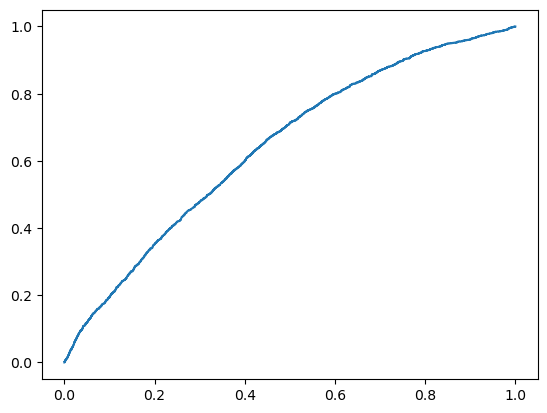

In [26]:
y_scores = mod.cross_val_predict(pipe_Model, X_train, y_train,
                                cv=5, method="predict_proba")
y_scores = y_scores[:, 1] 
fpr, tpr, thresholds = met.roc_curve(y_train, y_scores)
auc_score = met.roc_auc_score(y_train, y_scores)
plt.plot(fpr, tpr)


In [27]:
pipe_Model.fit(df.drop([Target_Col], axis=1), df[Target_Col])

Pipeline(steps=[('ct',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imp',
                                                                   SimpleImputer())]),
                                                  ['ncap rating',
                                                   'policyholder age',
                                                   'car age', 'height',
                                                   'engine volume',
                                                   'manufacturer', 'cylinder',
                                                   'population', 'time period',
                                                   'length', 'width',
                                                   'gross weight', 'gear box',
                                                   'airbags', 'turning radius',
                                                   'area danger level']),
                                                 ('cat',
                                                  Pipeline(steps=[('imp',
                                                                   SimpleImputer...
                                                   'cluster area', 'is ecw',
                                                   'fuel type', 'torque',
                                                   'transmission type',
                                                   'is rear window washer',
                                                   'is front fog lights',
                                                   'is brake assist',
                                                   'is power steering',
                                                   'is esc',
                                                   'is rear window defogger',
                                                   'engine type',
                                                   'is speed alert',
                                                   'steering type',
                                                   'is parking sensors',
                                                   'power',
                                                   'is day night rear view '
                                                   'mirror',
                                                   'model'])])),
                ('tree',
                 RandomForestClassifier(max_depth=4, min_samples_split=5,
                                        random_state=42))])

In [28]:
auc_score

0.6415805135242191

In [29]:
df_test = pd.read_excel(Data_Path2)

In [30]:
df_test.set_index("ID",inplace=True)

In [ ]:
#y_scores = mod.cross_val_predict(pipe_Model, df_test.drop([Target_Col], axis=1), df_test[Target_Col],
#                                cv=5, method="predict_proba")


In [32]:
y_scores=pipe_Model.predict_proba(df_test)

In [ ]:
#y_scores = y_scores[:, 1] 
#fpr, tpr, thresholds = met.roc_curve(df_test[Target_Col], y_scores)
#auc_score = met.roc_auc_score(df_test[Target_Col], y_scores)
#plt.plot(fpr, tpr)

In [34]:
auc_score

0.6415805135242191

In [35]:
df_submit = pd.DataFrame(y_scores,df_test.index)

In [36]:
df_submit.head()

,0
ID,
0,0.062352
1,0.051615
2,0.051070
3,0.058767
4,0.057684


In [37]:
df_submit.rename({0:"Probability"}, axis=1, inplace=True)

In [ ]:
df_submit.to_csv("submission1.csv")

In [38]:
feat_dict={}
for col, val in sorted(zip(X_train.columns, pipe_Model["tree"].feature_importances_), key=lambda x:x[1], reverse=True):
    feat_dict[col]=val
feat_dict

{'segment': 0.2435567567436236,
 'policyholder age': 0.1935280565396509,
 'is power door locks': 0.08273037450059605,
 'is driver seat height adjustable': 0.08062155218384111,
 'rear brakes type': 0.01807711616085774,
 'car age': 0.014982983146495791,
 'is parking camera': 0.014345204117063188,
 'fuel type': 0.013245896513609379,
 'gear box': 0.012512340617170487,
 'is central locking': 0.010969256395578532,
 'is ecw': 0.010860739027500916,
 'is tpms': 0.009628212717449033,
 'is rear window wiper': 0.008370514360613411,
 'is parking sensors': 0.0063082089252434834,
 'ncap rating': 0.005355224018714217,
 'engine volume': 0.004938736832899066,
 'is brake assist': 0.004934457835081927,
 'torque': 0.004835726523860849,
 'is front fog lights': 0.0043917427511229986,
 'turning radius': 0.004372415452594259,
 'is adjustable steering': 0.004054480662822743,
 'area danger level': 0.0032504342561352905,
 'is rear window washer': 0.0026779303877612327,
 'steering type': 0.0026310048902902805,
 'p

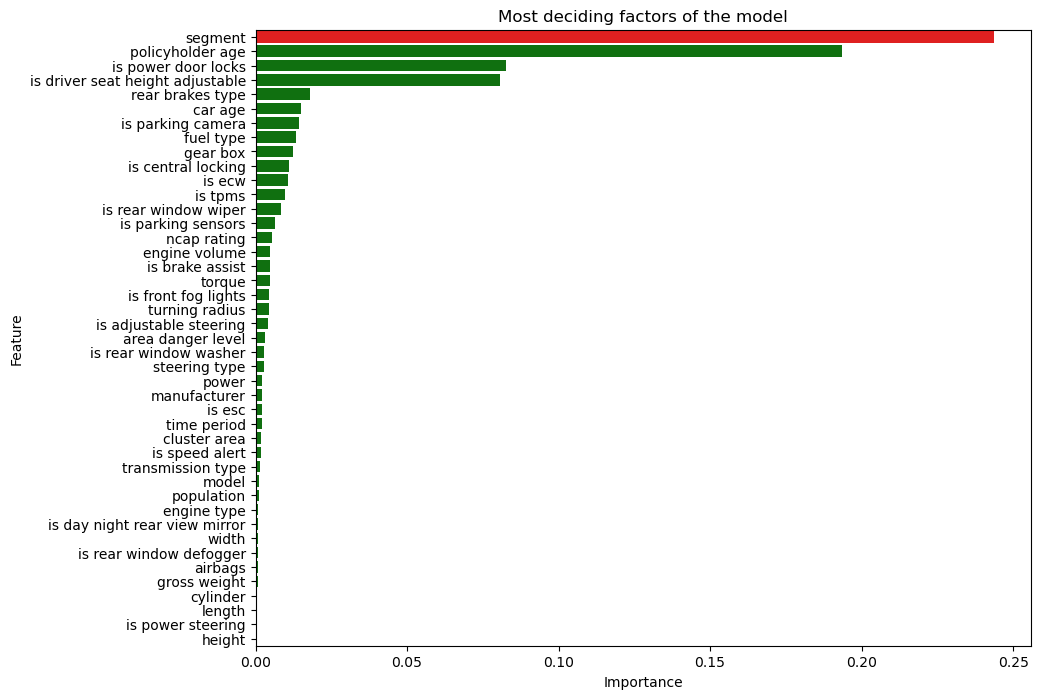

In [39]:
feat_df = pd.DataFrame({'Feature':feat_dict.keys(),'Importance':feat_dict.values()})
values = feat_df.Importance    
idx = feat_df.Feature
plt.figure(figsize=(10,8))
clrs = ['green' if (x < max(values)) else 'red' for x in values ]
sns.barplot(y=idx,x=values,palette=clrs).set(title='Most deciding factors of the model')
plt.show()

### 1. Linear Regression

In [49]:
pipe_LG = pip.Pipeline([
    ("ct", ct),
    ("log_reg", lin.LogisticRegression(random_state=42))
])
pipe_LG.fit(X_train, y_train)
y_scores = mod.cross_val_predict(pipe_LG, X_train, y_train,
                                cv=5, method="decision_function")
fpr, tpr, thresholds = met.roc_curve(y_train, y_scores)
auc_score = met.roc_auc_score(y_train, y_scores)
auc_score

0.5125041300718308

### 2. Decision Tree

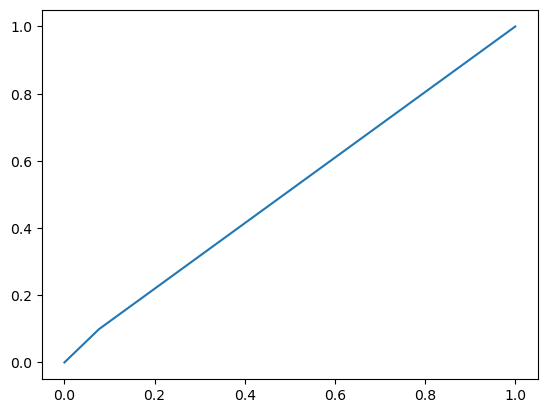

In [53]:
pipe_Tree = pip.Pipeline([
    ("ct", ct),
    ("tree", tree.DecisionTreeClassifier(random_state=42))
])
pipe_Tree.fit(X_train, y_train)
y_scores = mod.cross_val_predict(pipe_Tree, X_train, y_train,
                                cv=5, method="predict_proba")
y_scores = y_scores[:, 1] 
fpr, tpr, thresholds = met.roc_curve(y_train, y_scores)
auc_score = met.roc_auc_score(y_train, y_scores)
plt.plot(fpr, tpr)

### 3. Random Forest

In [95]:
pipe_Model= pip.Pipeline([
("ct", ct),
("tree", ens.RandomForestClassifier(random_state=42, max_depth=4, min_samples_split=5))
])

y_scores = mod.cross_val_predict(pipe_Model, X_train, y_train,
                                cv=5, method="predict_proba")
y_scores = y_scores[:, 1] 
fpr, tpr, thresholds = met.roc_curve(y_train, y_scores)
auc_score = met.roc_auc_score(y_train, y_scores)

In [96]:
auc_score

0.6415805135242191

## 5. Hyperparameter Tuning

### 1. Random Forest Classifier

In [66]:
import optuna as opt

In [118]:
def objective(trial, X_train, y_train):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 1000),
        'max_depth': trial.suggest_int('max_depth', 3,15 ),
        'min_samples_split': trial.suggest_int('min_samples_split', 1, 10),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 60),
        "random_state": 42,
    #    "n_iter_no_change": 50,  
    #    "tree__validation_fraction": 0.05,
    }
    
    pipe_Model= pip.Pipeline([
    ("ct", ct),
    ("tree", ens.RandomForestClassifier(**params))
    ])
    
    y_scores = mod.cross_val_predict(pipe_Model, X_train, y_train,
                                    cv=5, method="predict_proba")
    y_scores = y_scores[:, 1] 
    fpr, tpr, thresholds = met.roc_curve(y_train, y_scores)
    auc_score = met.roc_auc_score(y_train, y_scores)

    return auc_score

In [119]:
rfc_study = opt.create_study(direction="maximize")

[I 2023-01-05 20:27:18,565] A new study created in memory with name: no-name-e366f8c1-ebbe-4e8f-b351-0f69d63f7d18


In [127]:
func = lambda trial: objective(trial, X_train, y_train)

In [121]:
rfc_study.optimize(func, n_trials=10)


[I 2023-01-05 20:28:35,126] Trial 0 finished with value: 0.6441757342163401 and parameters: {'n_estimators': 931, 'max_depth': 5, 'min_samples_split': 8, 'min_samples_leaf': 38}. Best is trial 0 with value: 0.6441757342163401.
[I 2023-01-05 20:30:17,739] Trial 1 finished with value: 0.6462178464738115 and parameters: {'n_estimators': 974, 'max_depth': 10, 'min_samples_split': 8, 'min_samples_leaf': 34}. Best is trial 1 with value: 0.6462178464738115.
[I 2023-01-05 20:30:29,983] Trial 2 finished with value: 0.640818666529835 and parameters: {'n_estimators': 94, 'max_depth': 11, 'min_samples_split': 1, 'min_samples_leaf': 4}. Best is trial 1 with value: 0.6462178464738115.
[I 2023-01-05 20:31:10,044] Trial 3 finished with value: 0.6458169438941919 and parameters: {'n_estimators': 362, 'max_depth': 10, 'min_samples_split': 6, 'min_samples_leaf': 27}. Best is trial 1 with value: 0.6462178464738115.
[I 2023-01-05 20:31:30,633] Trial 4 finished with value: 0.643528674559366 and parameters: {

### 2. XGBoost 

In [131]:
def objective2(trial, X_train, y_train):
    params = {
        'subsample': trial.suggest_float('subsample', 0.1, 1),
        'min_child_weight': trial.suggest_float('min_child_weight',0,5),
        'max_depth': trial.suggest_int("max_depth",6,36),
        'lambda': trial.suggest_float('lambda',0,1),
        'gamma': trial.suggest_int("gamma",1,9),
        'eta': trial.suggest_float("eta",0.005,0.5),
        "random_state": 42,
    }
    
    pipe_Model= pip.Pipeline([
    ("ct", ct),
    ("xgb", xgb.XGBClassifier(**params))
    ])
    
    y_scores = mod.cross_val_predict(pipe_Model, X_train, y_train,
                                    cv=5, method="predict_proba")
    y_scores = y_scores[:, 1] 
    fpr, tpr, thresholds = met.roc_curve(y_train, y_scores)
    auc_score = met.roc_auc_score(y_train, y_scores)

    return auc_score

In [132]:
xgb_study = opt.create_study(direction="maximize")
func2 = lambda trial: objective2(trial, X_train, y_train)
xgb_study.optimize(func2, n_trials=10)


[I 2023-01-05 21:18:01,934] A new study created in memory with name: no-name-4f4e882e-6039-46bd-b0c4-ad6c152ef9af
[I 2023-01-05 21:18:24,785] Trial 0 finished with value: 0.5670436441443778 and parameters: {'subsample': 0.1378357577153958, 'min_child_weight': 3.1358706383165984, 'max_depth': 20, 'lambda': 0.38828348831670634, 'gamma': 4, 'eta': 0.31439725599441454}. Best is trial 0 with value: 0.5670436441443778.
[I 2023-01-05 21:19:13,091] Trial 1 finished with value: 0.6224251888723069 and parameters: {'subsample': 0.39097128676288184, 'min_child_weight': 0.7696093591072589, 'max_depth': 21, 'lambda': 0.3347265636942196, 'gamma': 6, 'eta': 0.05580117521568065}. Best is trial 1 with value: 0.6224251888723069.
[I 2023-01-05 21:19:51,412] Trial 2 finished with value: 0.596072724111642 and parameters: {'subsample': 0.8513893858925893, 'min_child_weight': 0.7837134607265206, 'max_depth': 13, 'lambda': 0.7797731450046114, 'gamma': 9, 'eta': 0.45858317455977476}. Best is trial 1 with value:

### 3. LGBM Classifier

In [141]:
def objective3(trial, X_train, y_train):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 100,1000, step=50),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
        "num_leaves": trial.suggest_int("num_leaves", 20, 3000, step=20),
        "max_depth": trial.suggest_int("max_depth", 3, 12),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 200, 10000, step=100),
#        "lambda_l1": trial.suggest_int("lambda_l1", 0, 100, step=5),
#        "lambda_l2": trial.suggest_int("lambda_l2", 0, 100, step=5),
        "min_gain_to_split": trial.suggest_float("min_gain_to_split", 0, 15),
#        "bagging_fraction": trial.suggest_float(
#            "bagging_fraction", 0.2, 0.95, step=0.1),
#        "bagging_freq": trial.suggest_categorical("bagging_freq", [1]),
#        "feature_fraction": trial.suggest_float(
#            "feature_fraction", 0.2, 0.95, step=0.1),
        "random_state": 42,
    }
    
    pipe_Model= pip.Pipeline([
    ("ct", ct),
    ("xgb", lgbm.LGBMClassifier(objective="binary", **params))
    ])
    
    y_scores = mod.cross_val_predict(pipe_Model, X_train, y_train,
                                    cv=5, method="predict_proba")
    y_scores = y_scores[:, 1] 
    fpr, tpr, thresholds = met.roc_curve(y_train, y_scores)
    auc_score = met.roc_auc_score(y_train, y_scores)

    return auc_score

In [ ]:
lgbm_study = opt.create_study(direction="maximize")
func3 = lambda trial: objective3(trial, X_train, y_train)
lgbm_study.optimize(func3, n_trials=10)

## 6. Final Ensemble

In [152]:
params= {'n_estimators': 931, 'max_depth': 5, 'min_samples_split': 8,
 'min_samples_leaf': 38}
pipe_tree= pip.Pipeline([
("ct", ct),
("tree", ens.RandomForestClassifier(#**params,
random_state=42))
])

In [153]:
params= {'subsample': 0.39097128676288184, 'min_child_weight': 0.7696093591072589,
 'max_depth': 21, 'lambda': 0.3347265636942196, 
'gamma': 6, 'eta': 0.05580117521568065}
pipe_xgb= pip.Pipeline([
("ct", ct),
("xgb", xgb.XGBClassifier(#**params,
random_state=42))
])

In [155]:
params = {'n_estimators': 350, 'learning_rate': 0.22655435082962339, 
'num_leaves': 2120, 'max_depth': 9, 'min_data_in_leaf': 4400, 
'min_gain_to_split': 0.9205761770315862}
pipe_lgbm= pip.Pipeline([
("ct", ct),
("xgb", lgbm.LGBMClassifier(objective="binary", random_state=42 #, **params
))
])

In [156]:
estimators = [("tree", pipe_tree),
                ("xgb", pipe_xgb),
                ("lgbm", pipe_lgbm)]
clf = ens.StackingClassifier(estimators=estimators)

In [157]:
y_scores = mod.cross_val_predict(clf, X_train, y_train,
                                cv=5, method="predict_proba")
y_scores = y_scores[:, 1] 
fpr, tpr, thresholds = met.roc_curve(y_train, y_scores)
auc_score = met.roc_auc_score(y_train, y_scores)
auc_score

0.6270921798694854

In [158]:
clf

StackingClassifier(estimators=[('tree',
                                Pipeline(steps=[('ct',
                                                 ColumnTransformer(transformers=[('num',
                                                                                  Pipeline(steps=[('imp',
                                                                                                   SimpleImputer())]),
                                                                                  ['ncap '
                                                                                   'rating',
                                                                                   'policyholder '
                                                                                   'age',
                                                                                   'car '
                                                                                   'age',
                                                                                   'height',
                                                                                   'engine '
                                                                                   'volume',
                                                                                   'manufacturer',
                                                                                   'cylinder',
                                                                                   'population',
                                                                                   'time '
                                                                                   'period',
                                                                                   'length',
                                                                                   'width',
                                                                                   'gross '
                                                                                   'weight',
                                                                                   'gear '
                                                                                   'box',
                                                                                   'airbags',
                                                                                   'turning '
                                                                                   'radius',
                                                                                   'area '
                                                                                   'd...
                                                                                   'torque',
                                                                                   'transmission '
                                                                                   'type',
                                                                                   'is '
                                                                                   'rear '
                                                                                   'window '
                                                                                   'washer',
                                                                                   'is '
                                                                                   'front '
                                                                                   'fog '
                                                                                   'lights',
                                                                                   'is '
                                                                                   'brake '
                                                                              